<a href="https://colab.research.google.com/github/karthikmnkrishna/Loan-default-prediction/blob/Build/Loan_Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOAN CASE STUDY

##DATA & LIBRARIES IMPORT

In [1370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1371]:
path = '/content/drive/My Drive/Masters/loan.csv'
df = pd.read_csv(path)
print(df.shape)

(39717, 111)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## DATA CLEANING AND FORMATING

###Checking if there is any incosistency in column names

In [1372]:
df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

The column names have no formating issue

Checking for columns that have only a single value,and hence may not be considered for analysis

In [1373]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,90.000000,9.000000,0.0000

In [1374]:
df.groupby(['acc_now_delinq','application_type','collections_12_mths_ex_med','initial_list_status','policy_code','pymnt_plan','chargeoff_within_12_mths','delinq_amnt','tax_liens']).count()['id']

acc_now_delinq  application_type  collections_12_mths_ex_med  initial_list_status  policy_code  pymnt_plan  chargeoff_within_12_mths  delinq_amnt  tax_liens
0               INDIVIDUAL        0.0                         f                    1            n           0.0                       0            0.0          39661
Name: id, dtype: int64

In [1375]:
df.drop(['acc_now_delinq','collections_12_mths_ex_med','initial_list_status','policy_code','application_type','pymnt_plan','chargeoff_within_12_mths','delinq_amnt','tax_liens','url'] ,axis = 1,inplace= True) #REMOVING URL, AS IT SEEMS TO BE A REPITION OF ID COLUMN 

Setting index as id . it seems to be the primary keys as it has all unique values and the description vouches our assumption

In [1376]:
df.set_index('id',inplace =True)

###Checking Rows for redundancy/inconsistency

In [1377]:
pd.set_option("max_colwidth", None)
df.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,...,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay towa

Both the header and footer look fine.There are no extra rows.

###TREATING MISSING VALUES

Lets oserve all the columns with non null and null values and get rid of the columns with only null

In [1378]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 1077501 to 87023
Data columns (total 100 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   member_id                       39717 non-null  int64  
 1   loan_amnt                       39717 non-null  int64  
 2   funded_amnt                     39717 non-null  int64  
 3   funded_amnt_inv                 39717 non-null  float64
 4   term                            39717 non-null  object 
 5   int_rate                        39717 non-null  object 
 6   installment                     39717 non-null  float64
 7   grade                           39717 non-null  object 
 8   sub_grade                       39717 non-null  object 
 9   emp_title                       37258 non-null  object 
 10  emp_length                      38642 non-null  object 
 11  home_ownership                  39717 non-null  object 
 12  annual_inc               

COLUMNS WITH ONLY NULL VALUES HAVE BEEN REMOVED.<br>
COLUMNS WITH TOO MANY NULL VALUES HAVE BEEN REMOVED (next_pymnt_d)<br>
ROWS WITH MINIMUM NULL VALUES  HAVE BEEN IGNORED IN SOME CASES<br>

In [1379]:
df.drop([ 'annual_inc_joint', 'dti_joint','mths_since_last_major_derog',
 'verification_status_joint','tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75',   'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd','tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit','next_pymnt_d','mths_since_last_record'  ],axis =1,inplace = True)

In [1380]:
df = df[~df.title.isna()]
df = df[~df.pub_rec_bankruptcies.isna()]
df = df[~df.last_pymnt_d.isna()]
df = df[~df.last_credit_pull_d.isna()] 

Cleaning Columns and Rows - after removing the null values <br>CLEANING DESC COLUMN AND FORMATING INTEREST RATE ,ZIP CODE ,Term and other date columns<br>
I'm surious to know if  emp_title or emp_length will give any thing interesting when it is not given.

In [1381]:
df.desc.fillna(' ' ,inplace= True)
df.revol_util.fillna(-1 ,inplace= True)#reomve if not useful
df.mths_since_last_delinq.fillna(-1 ,inplace= True)#reomve if not useful
df.emp_title.fillna('Not Given' ,inplace= True)#reomve if not useful
df.emp_length.fillna('Not Given' ,inplace= True)#reomve if not useful
df['desc'] = df.desc.str.replace('<br>' , '')
df['desc'] =df.desc.str.replace('Borrower added on ' , '')
df['desc'] = df.desc.str.replace('(1[0-2]|0[1-9])/(3[01]|[12][0-9]|0[1-9])/(1[0-2]|0[1-9])' , '')
df['desc'] =df.desc.str.replace('>' ,'')

In [1382]:
df['int_rate'] = df.int_rate.apply(lambda x : float(x.strip('%'))/100 )
df['revol_util'] = df.revol_util.apply(lambda x : float(x.strip('%'))/100 if (x != -1 ) else -1) # -1 so that we can regonize the columns and ignore if necessary

In [1383]:
df['zip_code'] = df.zip_code.str.replace('xx' ,'')

In [1384]:
df['term']= df.term.str.strip()

In [1385]:
df['last_credit_pull_d'] =df.last_credit_pull_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['issue_d'] =df.issue_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['earliest_cr_line'] =df.earliest_cr_line.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['last_pymnt_d'] =df.last_pymnt_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )

In [1386]:
df.isna().sum()

member_id                  0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
desc                       0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
mths_since_last_delinq     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_in

###CHECKING FOR OUTLIERS

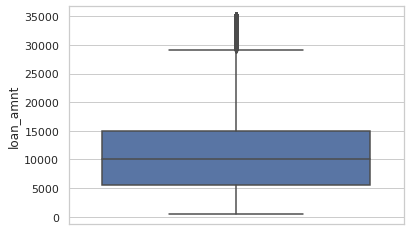

In [1387]:
sns.set(style="whitegrid")
sns.boxplot(y=df.loan_amnt)

In [1388]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,3.893700e+04,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,3.893700e+04,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000
mean,8.620738e+05,11247.970439,10973.287618,10548.512595,0.120418,324.756877,6.900425e+04,13.362382,0.145363,0.865732,12.030074,9.296428,0.055449,13392.270180,0.487790,22.152272,52.254103,52.011213,12211.472950,11750.108575,9834.079083,2281.970220,1.328033,94.095695,12.102286,2704.282732,0.043198
std,2.534601e+05,7471.739408,7199.326345,7104.374465,0.037430,208.820843,6.320403e+04,6.669048,0.489809,1.066685,21.990996,4.382289,0.237989,15848.581819,0.287468,11.395272,378.841331,377.479914,9067.533732,8929.109967,7078.255720,2625.009916,7.139203,684.381010,146.925319,4467.082745,0.204188
min,8.036400e+04,500.000000,500.000000,0.000000,0.054200,16.080000,4.000000e+03,0.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,33.730000,0.000000,0.000000,6.220000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,6.758090e+05,5500.000000,5400.000000,5000.000000,0.092500,167.340000,4.080000e+04,8.240000,0.000000,0.000000,-1.000000,6.000000,0.000000,3728.000000,0.255000,14.000000,0.000000,0.000000,5598.284713,5315.780000,4650.000000,666.730000,0.000000,0.000000,0.000000,221.190000,0.000000
50%,8.582830e+05,10000.000000,9700.000000,9000.000000,0.118600,280.390000,5.900400e+04,13.450000,0.000000,1.000000,-1.000000,9.000000,0.000000,8873.000000,0.494000,20.000000,0.000000,0.000000,9958.640000,9489.360000,8000.000000,1356.740000,0.000000,0.000000,0.000000,554.050000,0.000000
75%,1.050176e+06,15000.000000,15000.000000,14497.884390,0.146100,430.780000,8.250000e+04,18.630000,0.000000,1.000000,21.000000,12.000000,0.000000,17080.000000,0.724000,29.000000,0.000000,0.000000,16605.880000,16000.610000,13800.000000,2861.030000,0.000000,0.000000,0.000000,3344.420000,0.000000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,0.245900,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,0.999000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


DIGGING DEEPER ON ANNUAL INCOME
<BR>--out_prncp	out_prncp_inv<br>	total_pymnt	total_pymnt_inv	total_rec_prncp	total_rec_int,revol_bal

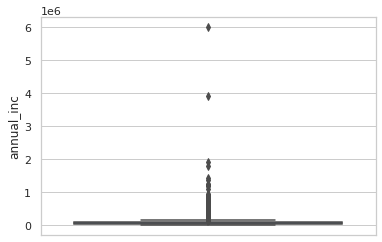

In [1389]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc)


In [1390]:
df.total_pymnt.quantile([0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99,1],)

0.000       33.730000
0.001      199.399520
0.010      854.751600
0.025     1290.786000
0.050     1939.690056
0.100     3005.160716
0.250     5598.284713
0.500     9958.640000
0.750    16605.880000
0.975    35624.909462
0.990    42341.333333
1.000    58563.679930
Name: total_pymnt, dtype: float64

In [1391]:
df.annual_inc.quantile([0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99 ,1],)

0.000       4000.000
0.001       8498.208
0.010      14400.000
0.025      19200.000
0.050      24000.000
0.100      30000.000
0.250      40800.000
0.500      59004.000
0.750      82500.000
0.975     175000.000
0.990     234853.440
1.000    6000000.000
Name: annual_inc, dtype: float64

In [1392]:
df = df[df.annual_inc.between(df.annual_inc.quantile(0), df.annual_inc.quantile(.99))]

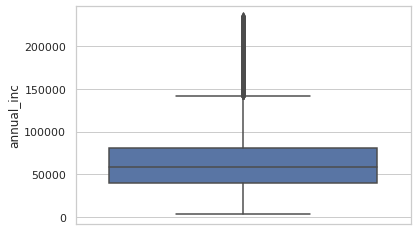

In [1393]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc)



##UNIVARIATE ANALYSIS


In [1394]:
def bar_plot( x,y ,data =df  ,sizerow=10 , sizecolumn =10 ,tabletoggle =True , axistoggle = 'off'):
  ax = data.groupby([x,y]).size().unstack().plot(kind='bar',stacked=True,figsize=(sizerow , sizecolumn),table = tabletoggle )
  plt.axis(axistoggle)
  plt.tight_layout()
  plt.show()


###Amount Distribution

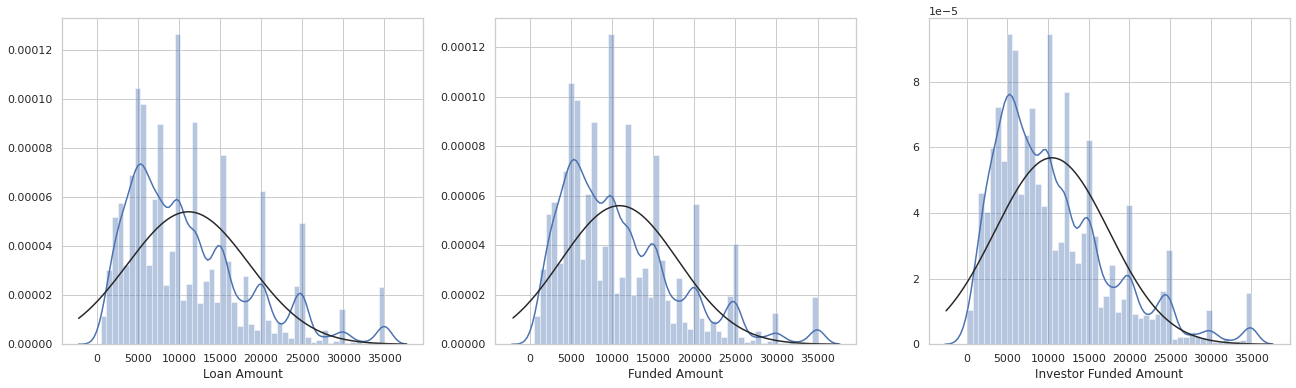

In [1395]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,3,1)
sns.distplot(df.loan_amnt,fit = norm)
plt.xlabel('Loan Amount')
plt.subplot(1,3,2)
sns.distplot(df.funded_amnt,fit = norm )
plt.xlabel('Funded Amount')
plt.subplot(1,3,3)
sns.distplot(df.funded_amnt_inv,fit = norm)
plt.xlabel('Investor Funded Amount')
plt.show()

###Loan Terms

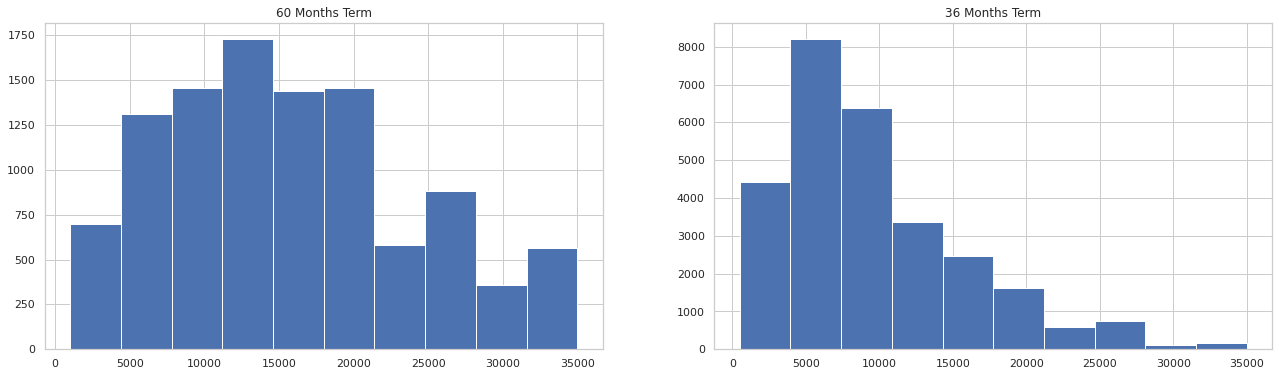

In [1396]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,2,1)
df[df.term == '60 months'].loan_amnt.hist()
plt.title('60 Months Term')
plt.subplot(1,2,2)
df[df.term == '36 months'].loan_amnt.hist()
plt.title('36 Months Term')
plt.show()

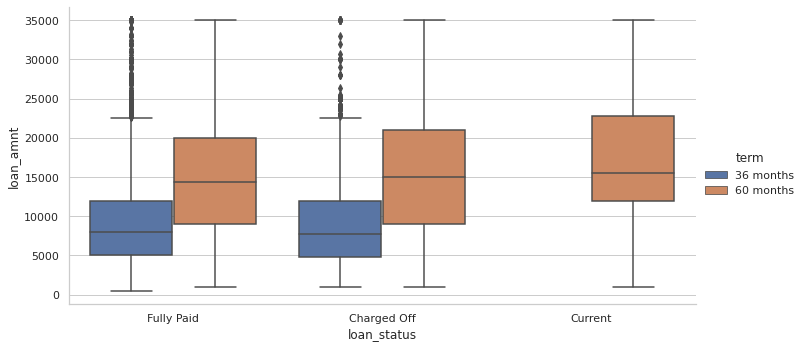

In [1397]:
sns.catplot(x="loan_status", y="loan_amnt", hue="term", kind="box", data=df,height=5, aspect=2)

###Loan distribution by issue Year

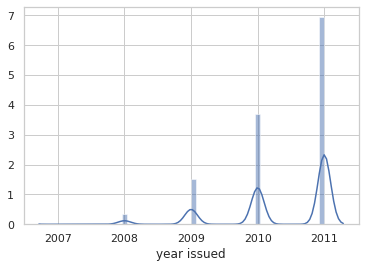

In [1398]:
df['issue_year']=pd.DatetimeIndex(df.issue_d).year
sns.distplot(df.issue_year , hist=True, hist_kws={"color": "b", "alpha":.5, "rwidth":41 , "histtype" : "stepfilled"})
plt.xlabel('year issued')
plt.show()

###Impact of Verification status

In [1399]:
pd.crosstab(index=  [df.verification_status],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
verification_status,,,
Not Verified,0.122663,0.014099,0.863238
Source Verified,0.143017,0.031082,0.825901
Verified,0.159591,0.047060,0.793350


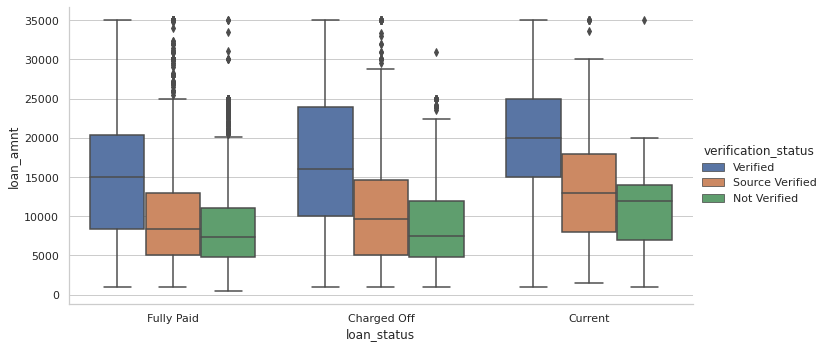

In [1400]:
sns.catplot(x="loan_status", y="loan_amnt", hue="verification_status", kind="box", data=df,height=5, aspect=2)

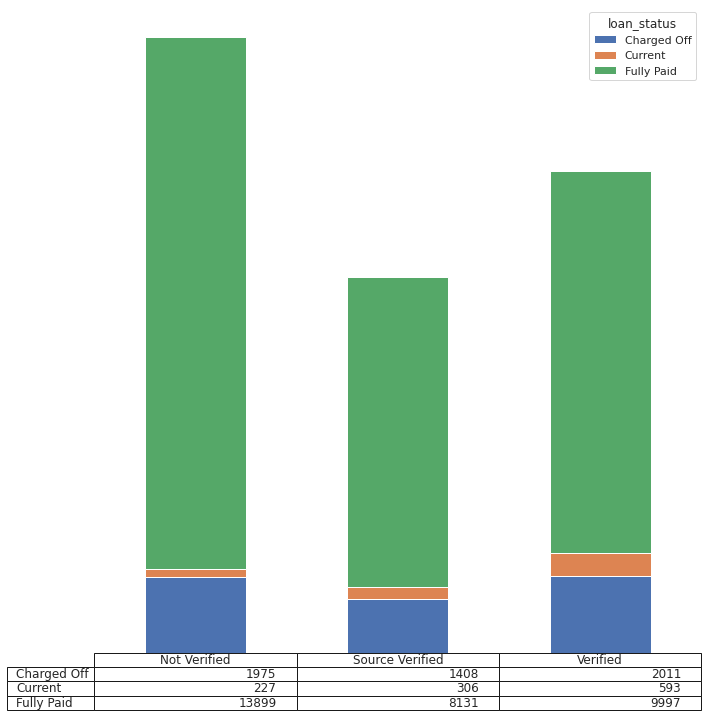

In [1401]:
bar_plot('verification_status' ,'loan_status')

###loan amount 

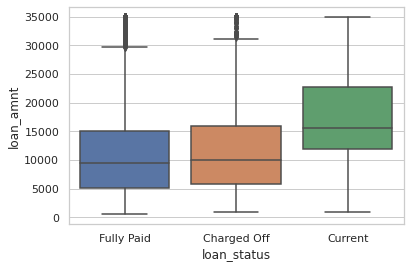

In [1402]:
sns.set(style="whitegrid")
sns.boxplot(y=df.loan_amnt , x= df.loan_status)

Loan amount doesnt seem to have major impact on status , although loan amount is more varied in case of charged off loans.

###Annual Income<br>

LETS OBSERVE IMPACT OF ANNUAL INCOME ON LOAN STATUS

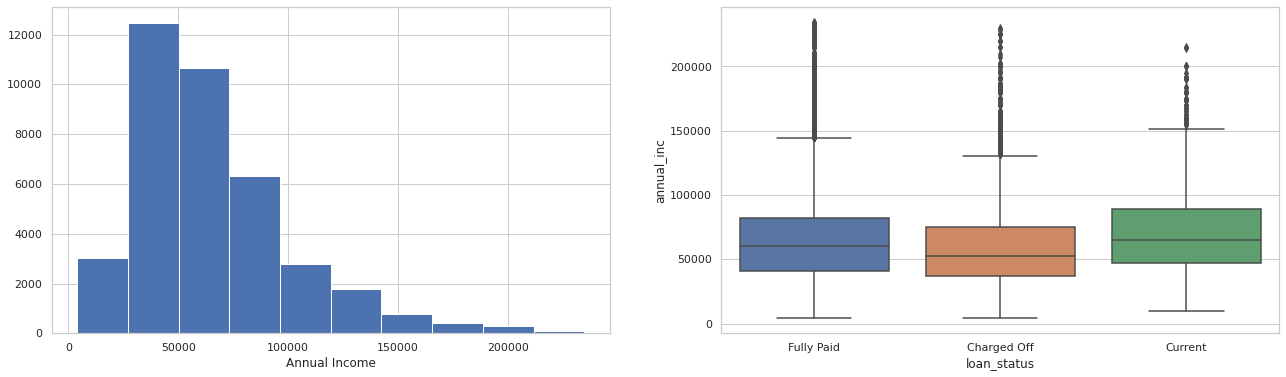

In [1403]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,2,1)
df.annual_inc.hist()
plt.xlabel('Annual Income')
plt.subplot(1,2,2)
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc , x= df.loan_status)
plt.show()

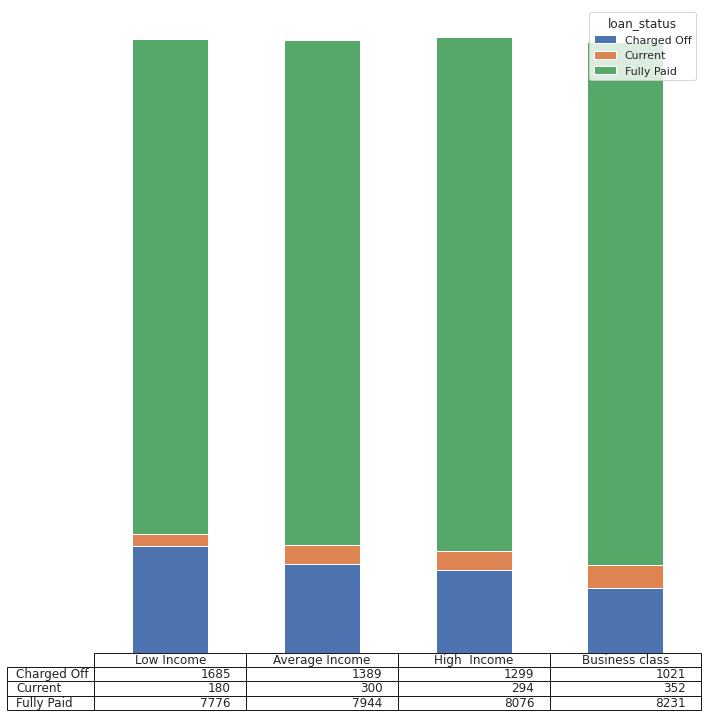

In [1404]:
df['annual_inc_bin'] = pd.qcut(df.annual_inc, 4, labels=['Low Income','Average Income','High  Income' ,'Business class'],duplicates = 'drop')
bar_plot(x='annual_inc_bin',y='loan_status' )

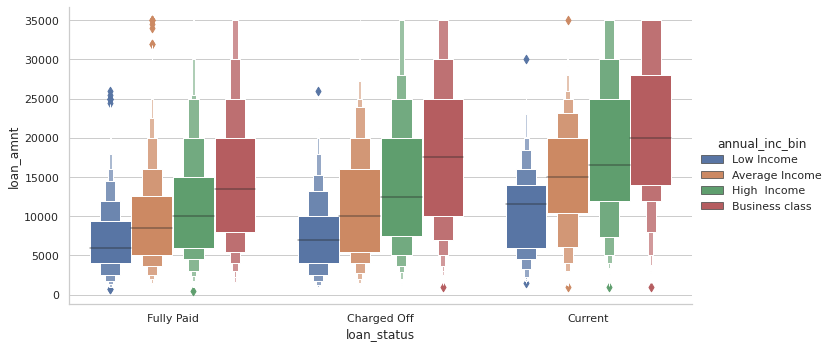

In [1405]:
sns.catplot(x="loan_status", y="loan_amnt", hue="annual_inc_bin", kind="boxen", data=df,height=5, aspect=2)

the annual income seems to be on the lower side in case of charged off loans

###CHECKING THE IMPACT OF dti on LOAN STATUS

In [1406]:
df.dti.describe()

count    38547.000000
mean        13.423189
std          6.654058
min          0.000000
25%          8.330000
50%         13.510000
75%         18.680000
max         29.990000
Name: dti, dtype: float64

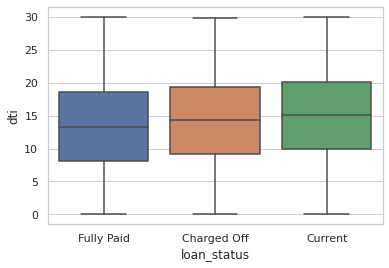

In [1407]:
sns.set(style="whitegrid")
sns.boxplot(y=df.dti , x= df.loan_status) 

###DTI Score analysis

In [1408]:
df.dti.describe()

count    38547.000000
mean        13.423189
std          6.654058
min          0.000000
25%          8.330000
50%         13.510000
75%         18.680000
max         29.990000
Name: dti, dtype: float64

In [1409]:
df.dti.quantile([0,.2,.4,.6, .8,1])

0.0     0.000
0.2     7.130
0.4    11.520
0.6    15.466
0.8    19.830
1.0    29.990
Name: dti, dtype: float64

In [1410]:
df['dti_bin'] = pd.qcut(df.dti, 4, labels=False,duplicates = 'drop')
pd.crosstab([df.dti_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
dti_bin,,,
0,0.119085,0.021021,0.859894
1,0.133638,0.029201,0.837161
2,0.148398,0.029244,0.822358
3,0.158666,0.037406,0.803928


As Dti increases , there is a slight increase in loan chared off

###CHECKING THE IMPACT OF LAST 6 MONTHS ENQUIRY on LOAN STATUS

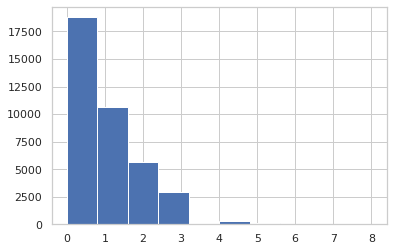

In [1411]:
df.inq_last_6mths.hist()

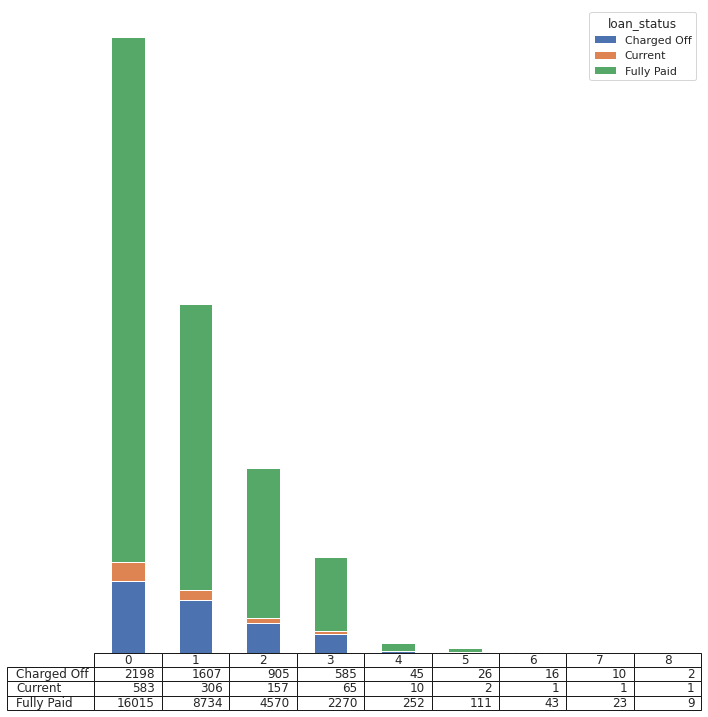

In [1412]:
bar_plot('inq_last_6mths' , 'loan_status')

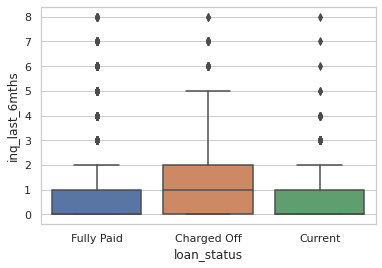

In [1413]:
sns.set(style="whitegrid")
sns.boxplot(y=df.inq_last_6mths , x= df.loan_status) 

In [1414]:
pd.crosstab(df.inq_last_6mths ,df.loan_status ,values= df.loan_amnt,aggfunc= 'count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
inq_last_6mths,,,
0,0.116940,0.031017,0.852043
1,0.150935,0.028740,0.820325
2,0.160689,0.027876,0.811435
3,0.200342,0.022260,0.777397
4,0.146580,0.032573,0.820847
5,0.187050,0.014388,0.798561
6,0.266667,0.016667,0.716667
7,0.294118,0.029412,0.676471
8,0.166667,0.083333,0.750000


chances of loan being charged off seems to increase with increase in enquiries

###checking impact of interest rate

In [1415]:
df.int_rate.describe()

count    38547.000000
mean         0.120263
std          0.037355
min          0.054200
25%          0.090700
50%          0.118600
75%          0.145900
max          0.245900
Name: int_rate, dtype: float64

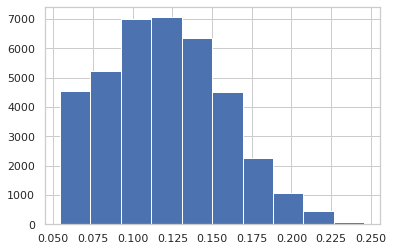

In [1416]:
df.int_rate.hist()

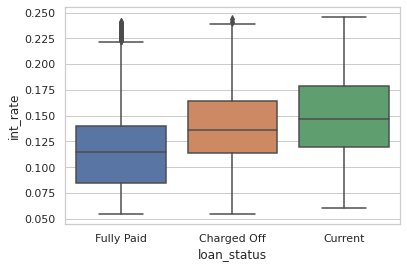

In [1417]:
sns.set(style="whitegrid")
sns.boxplot(y=df.int_rate , x= df.loan_status) 

Increase in intrest rate  increases the chances of loan being charged off

###checking impact of utilization rate

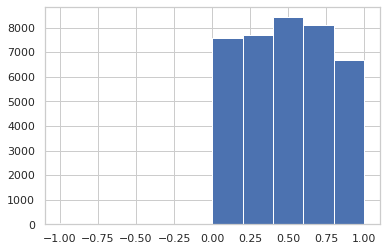

In [1418]:
df.revol_util.hist()

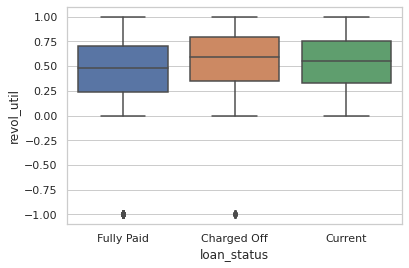

In [1419]:
sns.set(style="whitegrid")
sns.boxplot(y=df.revol_util , x= df.loan_status) 

Increase in utilization of revolving line  increases the chances of loan being charged off

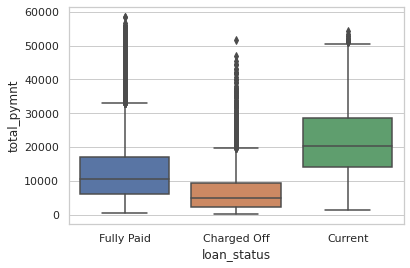

In [1420]:
sns.set(style="whitegrid")
sns.boxplot(y=df.total_pymnt , x= df.loan_status) 

###Grade

In [1421]:
#df.groupby(['grade','loan_status'])['loan_amnt'].describe()
pd.crosstab(index = [df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059682,0.004053,0.936265
B,0.117159,0.029397,0.853444
C,0.164319,0.033555,0.802126
D,0.208325,0.042212,0.749463
E,0.249453,0.064187,0.686360
F,0.301887,0.070506,0.627607
G,0.321192,0.056291,0.622517


###Purpose

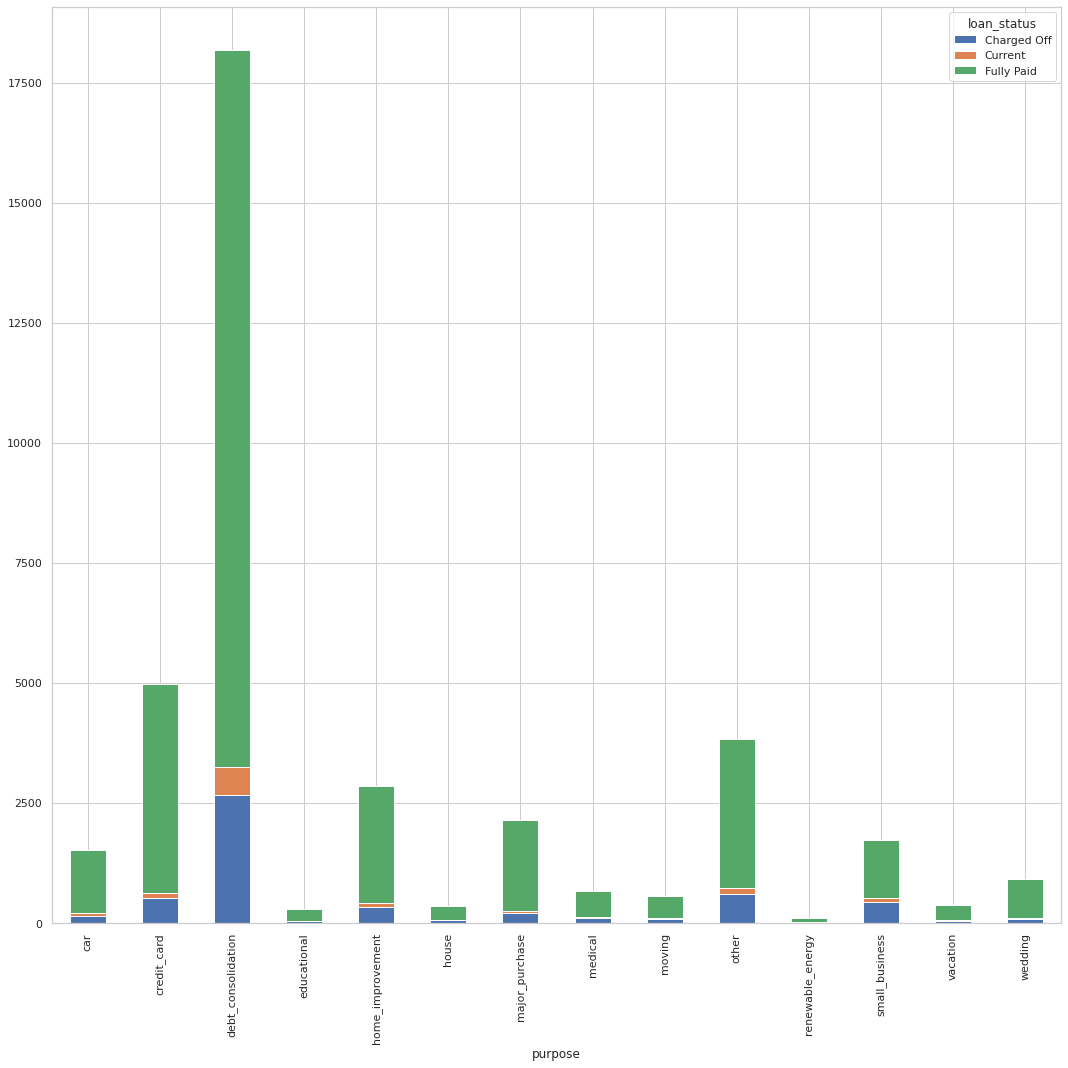

In [1422]:
bar_plot('purpose', 'loan_status',tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [1423]:
pd.crosstab([df.purpose],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.103018,0.032808,0.864173
credit_card,0.105474,0.020453,0.874073
debt_consolidation,0.146960,0.031912,0.821128
educational,0.163333,0.000000,0.836667
home_improvement,0.114938,0.034095,0.850967
house,0.151099,0.038462,0.810440
major_purchase,0.098552,0.017282,0.884166
medical,0.153846,0.017751,0.828402
moving,0.154930,0.012324,0.832746


###Region Analysis

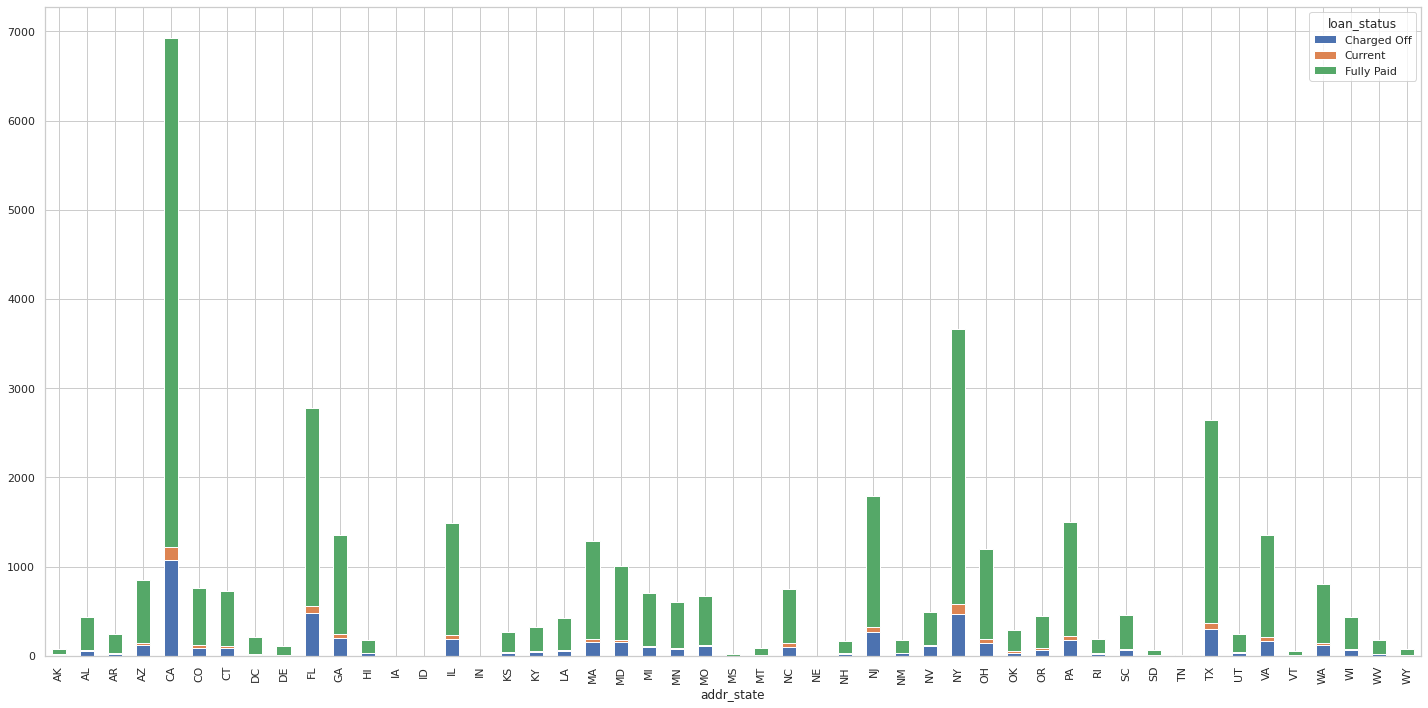

In [1424]:
bar_plot('addr_state', 'loan_status' , axistoggle= 'on',tabletoggle= False,sizerow= 20)

In [1425]:
pd.crosstab([df.addr_state],df.loan_status,values=df.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
addr_state,,,
AK,0.179487,0.025641,0.794872
AL,0.117914,0.038549,0.843537
AR,0.111570,0.041322,0.847107
AZ,0.140351,0.035088,0.824561
CA,0.154856,0.021504,0.823640
CO,0.121532,0.034346,0.844122
CT,0.125517,0.033103,0.841379
DC,0.066351,0.014218,0.919431
DE,0.099099,0.009009,0.891892


In [1426]:
#map states to regions
states = {
     'AK' :  'West' ,  'AL' :  'South' ,  'AR' :  'South' ,  'AZ' :  'West' ,  'CA' :  'West' ,  'CO' :  'West' ,  'CT' :  'Northeast' ,
       'DC' :  'South' ,  'DE' :  'South' ,  'FL' :  'South' ,  'GA' :  'South' ,  'HI' :  'West' ,  'IA' :  'Midwest' ,  'ID' :  'West' , 
        'IL' :  'Midwest' ,  'IN' :  'Midwest' ,  'KS' :  'Midwest' ,  'KY' :  'South' ,  'LA' :  'South' ,  'MA' :  'Northeast' ,  'MD' :  'South' , 
         'ME' :  'Northeast' ,  'MI' :  'Midwest' ,  'MN' :  'Midwest' ,  'MO' :  'Midwest' ,  'MS' :  'South' ,  'MT' :  'West' ,  'NC' :  'South' ,
          'ND' :  'Midwest' ,  'NE' :  'Midwest' ,  'NH' :  'Northeast' ,  'NJ' :  'Northeast' ,  'NM' :  'West' ,  'NV' :  'West' ,  'NY' :  'Northeast' , 
          'OH' :  'Midwest' ,  'OK' :  'South' ,  'OR' :  'West' ,  'PA' :  'Northeast' ,  'RI' :  'Northeast' ,  'SC' :  'South' ,  'SD' :  'Midwest' , 
          'TN' :  'South' ,  'TX' :  'South' ,  'UT' :  'West' ,  'VA' :  'South' ,  'VT' :  'Northeast' ,  'WA' :  'West' ,  'WI' :  'Midwest' , 
          'WV' :  'South' ,  'WY' :  'West' 
}
df['Region']= df['addr_state'].map(states)


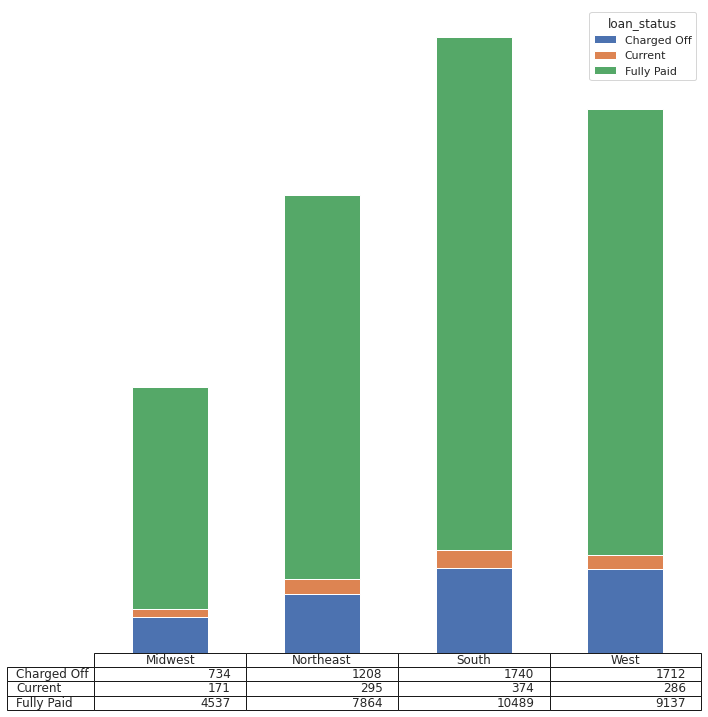

In [1427]:
bar_plot('Region' , 'loan_status')


In [1428]:
pd.crosstab([df.Region],df.loan_status,values=df.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
Region,,,
Midwest,0.134877,0.031422,0.833701
Northeast,0.128963,0.031494,0.839543
South,0.138062,0.029675,0.832262
West,0.153749,0.025685,0.820566


In [1429]:
pd.crosstab(index = [df.term] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
term,,,
36 months,0.107976,0.000000,0.892024
60 months,0.225563,0.107484,0.666953


##BIVARIATE ANALYSIS

###Correlation

In [1430]:
rs = np.random.RandomState(0)
cor = df[['annual_inc','collection_recovery_fee','dti','inq_last_6mths','installment','last_pymnt_amnt','loan_amnt','open_acc','out_prncp','out_prncp_inv','pub_rec','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']].corr()
cor.style.background_gradient(cmap='coolwarm')

,annual_inc,collection_recovery_fee,dti,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,open_acc,out_prncp,out_prncp_inv,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
annual_inc,1.000000,0.022384,-0.109833,0.036691,0.416697,0.218418,0.418319,0.261490,0.058281,0.058059,-0.021815,-0.018017,0.421907,0.046324,0.378140,0.397305,0.385976,0.283716,0.016612,0.399796
collection_recovery_fee,0.022384,1.000000,0.011382,0.012571,0.075244,-0.041266,0.073203,0.007035,-0.011342,-0.011330,-0.004855,-0.004962,0.024839,0.027599,0.011238,0.024375,0.017808,0.033948,0.086137,-0.058805
dti,-0.109833,0.011382,1.000000,0.003897,0.064319,0.009462,0.075419,0.294025,0.037123,0.037046,-0.005986,0.004679,0.244056,0.274924,0.235118,0.072865,0.075391,0.111571,-0.011277,0.049619
inq_last_6mths,0.036691,0.012571,0.003897,1.000000,0.004039,0.027030,0.004255,0.091795,-0.010694,-0.010357,0.025559,0.016876,-0.025498,-0.066170,0.111035,-0.013057,-0.020273,0.021912,0.031921,-0.026769
installment,0.416697,0.075244,0.064319,0.004039,1.000000,0.401941,0.929214,0.170098,0.126642,0.126483,-0.045355,-0.031537,0.309228,0.100023,0.225858,0.857798,0.832142,0.635343,0.057987,0.851232
last_pymnt_amnt,0.218418,-0.041266,0.009462,0.027030,0.401941,1.000000,0.448591,0.078346,-0.067532,-0.067461,-0.031465,-0.021407,0.116776,-0.015829,0.161260,0.474592,0.463954,0.189892,-0.059664,0.544096
loan_amnt,0.418319,0.073203,0.075419,0.004255,0.929214,0.448591,1.000000,0.175037,0.195089,0.194760,-0.050453,-0.034928,0.315143,0.070044,0.251737,0.887213,0.864885,0.730652,0.046756,0.851855
open_acc,0.261490,0.007035,0.294025,0.091795,0.170098,0.078346,0.175037,1.000000,0.028104,0.027916,0.002068,0.007497,0.287989,-0.082871,0.685304,0.160391,0.153025,0.121555,-0.018006,0.158737
out_prncp,0.058281,-0.011342,0.037123,-0.010694,0.126642,-0.067532,0.195089,0.028104,1.000000,0.999823,-0.012743,-0.009802,0.058891,0.038341,0.030799,0.241194,0.247488,0.384648,-0.003666,0.168242
out_prncp_inv,0.058059,-0.011330,0.037046,-0.010357,0.126483,-0.067461,0.194760,0.027916,0.999823,1.000000,-0.012983,-0.010097,0.058666,0.038506,0.030607,0.240862,0.247475,0.384299,-0.003780,0.167944


###Check Grade/Subgrade/Term

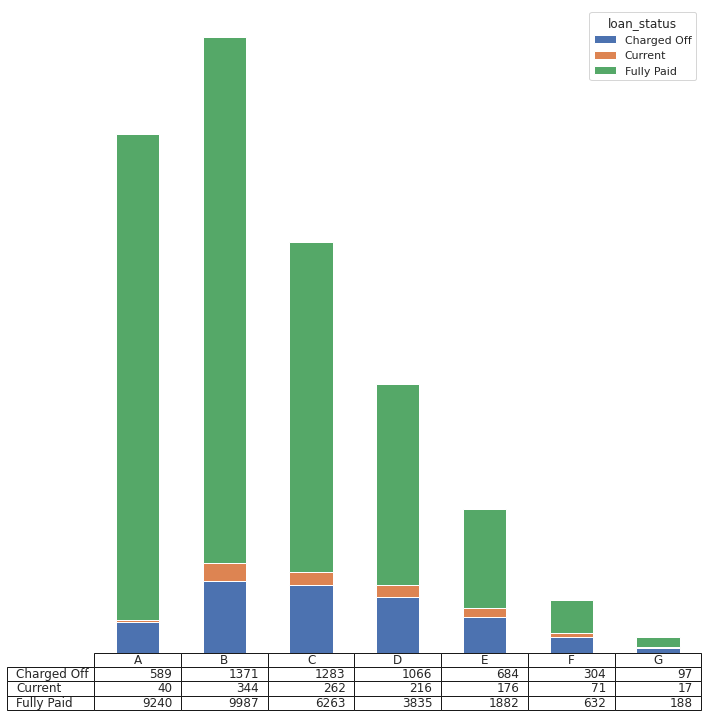

In [1431]:
bar_plot('grade','loan_status')

In [1432]:
pd.crosstab(index = [df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059682,0.004053,0.936265
B,0.117159,0.029397,0.853444
C,0.164319,0.033555,0.802126
D,0.208325,0.042212,0.749463
E,0.249453,0.064187,0.686360
F,0.301887,0.070506,0.627607
G,0.321192,0.056291,0.622517


In [1433]:
pd.crosstab(index = [df.term ,df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status      Charged Off   Current  Fully Paid
term      grade                                   
36 months A         0.058499  0.000000    0.941501
          B         0.103578  0.000000    0.896422
          C         0.143534  0.000000    0.856466
          D         0.173899  0.000000    0.826101
          E         0.194581  0.000000    0.805419
          F         0.239362  0.000000    0.760638
          G         0.377358  0.000000    0.622642
60 months A         0.085450  0.092379    0.822171
          B         0.162991  0.128598    0.708411
          C         0.213546  0.113028    0.673425
          D         0.259747  0.105263    0.634990
          E         0.272539  0.091192    0.636269
          F         0.316239  0.086691    0.597070
          G         0.309237  0.068273    0.622490

In [1434]:
pd.crosstab(index = [df.grade,df.sub_grade,df.term ] , columns = [df.loan_status] , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status                Charged Off   Current  Fully Paid
grade sub_grade term                                        
A     A1        36 months     0.026762  0.000000    0.973238
      A2        36 months     0.048797  0.000000    0.951203
                60 months     0.071429  0.000000    0.928571
      A3        36 months     0.057076  0.000000    0.942924
                60 months     0.024390  0.000000    0.975610
...                                ...       ...         ...
G     G3        60 months     0.348837  0.069767    0.581395
      G4        36 months     0.333333  0.000000    0.666667
                60 months     0.204545  0.045455    0.750000
      G5        36 months     0.666667  0.000000    0.333333
                60 months     0.210526  0.052632    0.736842

[69 rows x 3 columns]

###Home Ownership ,Verification Status and Term

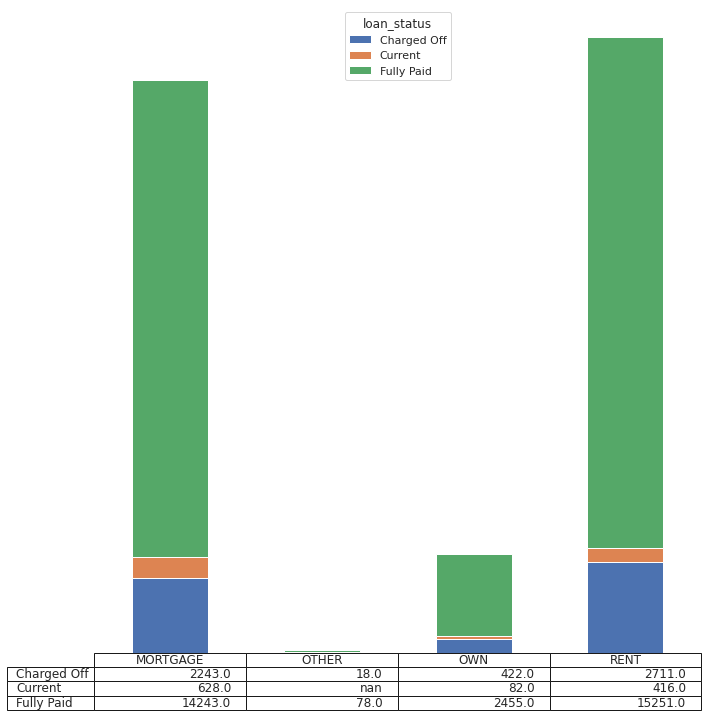

In [1435]:
bar_plot('home_ownership','loan_status')

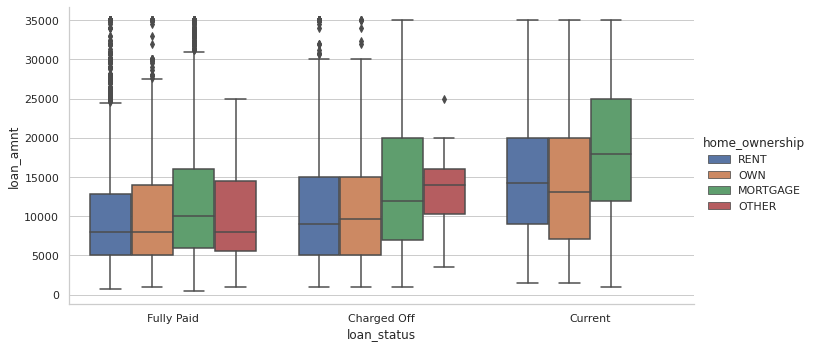

In [1436]:
sns.catplot(x="loan_status", y="loan_amnt", hue="home_ownership", kind="box", data=df,height=5, aspect=2)

In [1437]:
pd.crosstab(index=  [df.home_ownership],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
home_ownership,,,
MORTGAGE,0.131062,0.036695,0.832243
OTHER,0.187500,0.000000,0.812500
OWN,0.142616,0.027712,0.829672
RENT,0.147513,0.022636,0.829851


In [1438]:
pd.crosstab(index=  [df.term,df.home_ownership],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status               Charged Off   Current  Fully Paid
term      home_ownership                                   
36 months MORTGAGE           0.096459  0.000000    0.903541
          OTHER              0.178947  0.000000    0.821053
          OWN                0.105335  0.000000    0.894665
          RENT               0.117270  0.000000    0.882730
60 months MORTGAGE           0.202875  0.112848    0.684277
          OTHER              1.000000  0.000000    0.000000
          OWN                0.253012  0.109772    0.637216
          RENT               0.250781  0.099928    0.649291

In [1439]:
pd.crosstab(index= [df.verification_status,df.home_ownership,df.term ] ,columns= [df.loan_status] , values= df.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status                                   Charged Off   Current  Fully Paid
verification_status home_ownership term                                        
Not Verified        MORTGAGE       36 months     0.098337  0.000000    0.901663
                                   60 months     0.194712  0.092949    0.712340
                    OTHER          36 months     0.176471  0.000000    0.823529
                                   60 months     1.000000  0.000000    0.000000
                    OWN            36 months     0.107642  0.000000    0.892358
                                   60 months     0.207254  0.119171    0.673575
                    RENT           36 months     0.116626  0.000000    0.883374
                                   60 months     0.210748  0.092729    0.696523
Source Verified     MORTGAGE       36 months     0.080943  0.000000    0.919057
                                   60 months     0.204730  0.111604    0.683666
                    OTHER          36 months     0.100000  0.000000    0.900000
                    OWN            36 months     0.091954  0.000000    0.908046
                                   60 months     0.278481  0.118143    0.603376
                    RENT           36 months     0.117988  0.000000    0.882012
                                   60 months     0.262129  0.091962    0.645909
Verified            MORTGAGE       36 months     0.104727  0.000000    0.895273
                                   60 months     0.205466  0.121795    0.672740
                    OTHER          36 months     0.205882  0.000000    0.794118
                    OWN            36 months     0.114165  0.000000    0.885835
                                   60 months     0.261830  0.097792    0.640379
                    RENT           36 months     0.117784  0.000000    0.882216
                                   60 months     0.262957  0.109656    0.627387

###Purpose/Term

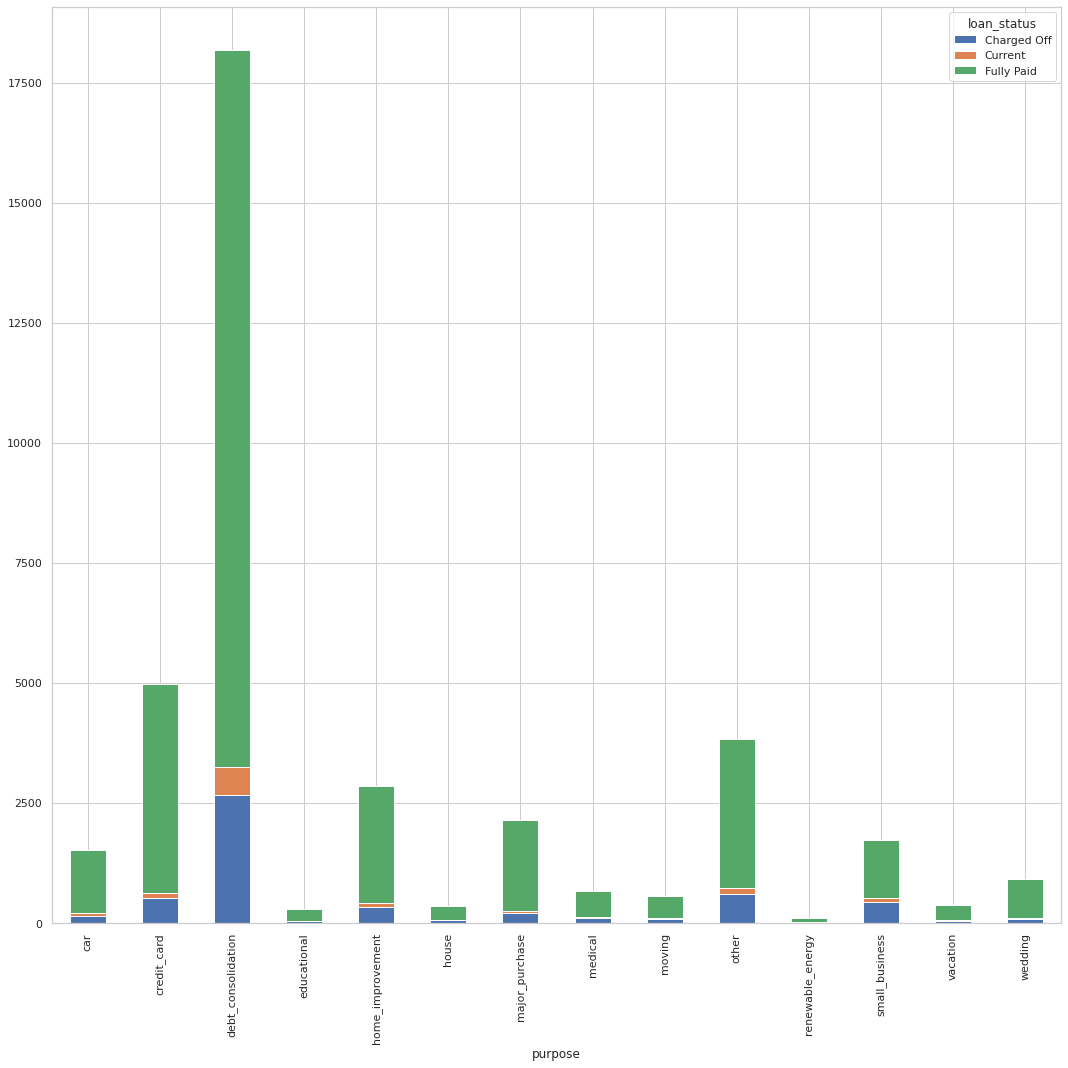

In [1440]:
bar_plot('purpose', 'loan_status',tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [1441]:
pd.crosstab([df.purpose],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.103018,0.032808,0.864173
credit_card,0.105474,0.020453,0.874073
debt_consolidation,0.146960,0.031912,0.821128
educational,0.163333,0.000000,0.836667
home_improvement,0.114938,0.034095,0.850967
house,0.151099,0.038462,0.810440
major_purchase,0.098552,0.017282,0.884166
medical,0.153846,0.017751,0.828402
moving,0.154930,0.012324,0.832746


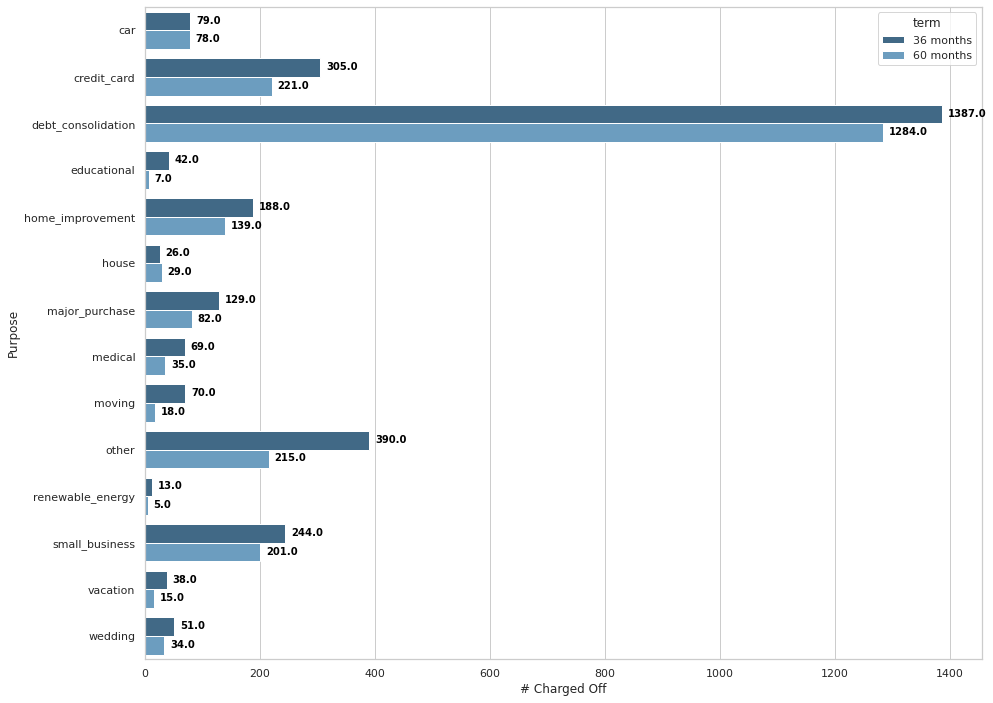

In [1442]:
df1= pd.crosstab([df.purpose ,df.term ],[df.loan_status],values=df.loan_amnt,aggfunc='count').reset_index().fillna(0)
fig, ax = plt.subplots(figsize=(15,12))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Charged Off' ,y ='purpose',data =  df1 ,hue = 
            'term' ,palette= 'Blues_d').set(
                xlabel ='# Charged Off' , ylabel= 'Purpose')
#to get values next to bar plots(THIS WILL THROW WARNINGS , WHICH IS IGNORED)
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.25, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='black')
plt.show()


In [1443]:
pd.crosstab([df.purpose ,df.term ],[df.loan_status],values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status                   Charged Off   Current  Fully Paid
purpose            term                                        
car                36 months     0.081950  0.000000    0.918050
                   60 months     0.139286  0.089286    0.771429
credit_card        36 months     0.077079  0.000000    0.922921
                   60 months     0.214563  0.099029    0.686408
debt_consolidation 36 months     0.108964  0.000000    0.891036
                   60 months     0.235769  0.106500    0.657730
educational        36 months     0.147887  0.000000    0.852113
                   60 months     0.437500  0.000000    0.562500
home_improvement   36 months     0.095577  0.000000    0.904423
                   60 months     0.158314  0.110478    0.731207
house              36 months     0.104418  0.000000    0.895582
                   60 months     0.252174  0.121739    0.626087
major_purchase     36 months     0.076512  0.000000    0.923488
                   60 months     0.180220  0.081319    0.738462
medical            36 months     0.134766  0.000000    0.865234
                   60 months     0.213415  0.073171    0.713415
moving             36 months     0.148936  0.000000    0.851064
                   60 months     0.183673  0.071429    0.744898
other              36 months     0.129870  0.000000    0.870130
                   60 months     0.255952  0.150000    0.594048
renewable_energy   36 months     0.173333  0.000000    0.826667
                   60 months     0.200000  0.040000    0.760000
small_business     36 months     0.210345  0.000000    0.789655
                   60 months     0.348958  0.128472    0.522569
vacation           36 months     0.120635  0.000000    0.879365
                   60 months     0.250000  0.100000    0.650000
wedding            36 months     0.072857  0.000000    0.927143
                   60 months     0.159624  0.093897    0.746479

Long term loans for vacation , education ,small business ,credit card or for no reasons is a bad idea

###DESC 

Lets check if length of description has any effect on the outcome

In [1444]:
df['desc_len'] = df.desc.apply(lambda c :len(c))

In [1445]:
df.desc_len.describe()

count    38547.000000
mean       265.162633
std        408.705731
min          1.000000
25%          1.000000
50%        117.000000
75%        356.000000
max       3966.000000
Name: desc_len, dtype: float64

In [1446]:
df.desc_len.quantile([.1, .25, .5, .75,.80,.90,.95]) 

0.10       1.0
0.25       1.0
0.50     117.0
0.75     356.0
0.80     438.0
0.90     709.0
0.95    1030.0
Name: desc_len, dtype: float64

In [1447]:
df['desc_len_bin'] = pd.qcut(df.desc_len, 4, labels=False,duplicates = 'drop')

In [1448]:

pd.crosstab([df.desc_len_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
desc_len_bin,,,
0,0.141142,0.031974,0.826883
1,0.145015,0.030524,0.824461
2,0.132432,0.022349,0.845218


###CHECK ON FICO SCORE 

In [1449]:
df['fico']=df.desc.apply(lambda x : 1 if re.search('fico' ,x ) else 0 )

In [1450]:
#df[df.fico == 1]
pd.crosstab([df.fico  ],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
fico,,,
0,0.139809,0.029229,0.830963
1,0.347826,0.000000,0.652174


In [1451]:
dff =df[df.fico == 1]
pd.crosstab([dff.purpose  ],dff.loan_status,values=dff.loan_amnt,aggfunc='count',
           normalize='columns')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.125,0.000000
credit_card,0.125,0.066667
debt_consolidation,0.750,0.533333
house,0.000,0.066667
major_purchase,0.000,0.066667
other,0.000,0.133333
small_business,0.000,0.133333


Higher chances of loan getting charged off if fico is mentioned on desc<br>
The cases where charged off is higher are mostly(~88%) debt consolidation/other when Fico is mentioned.

###Interest Rates/Employee length/Grade

Binning Interest rates into quartiles

In [1452]:
df.int_rate.quantile([0.25,0.5,0.75,1])

0.25    0.0907
0.50    0.1186
0.75    0.1459
1.00    0.2459
Name: int_rate, dtype: float64

In [1453]:
df['interest_bin'] = pd.qcut(df.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

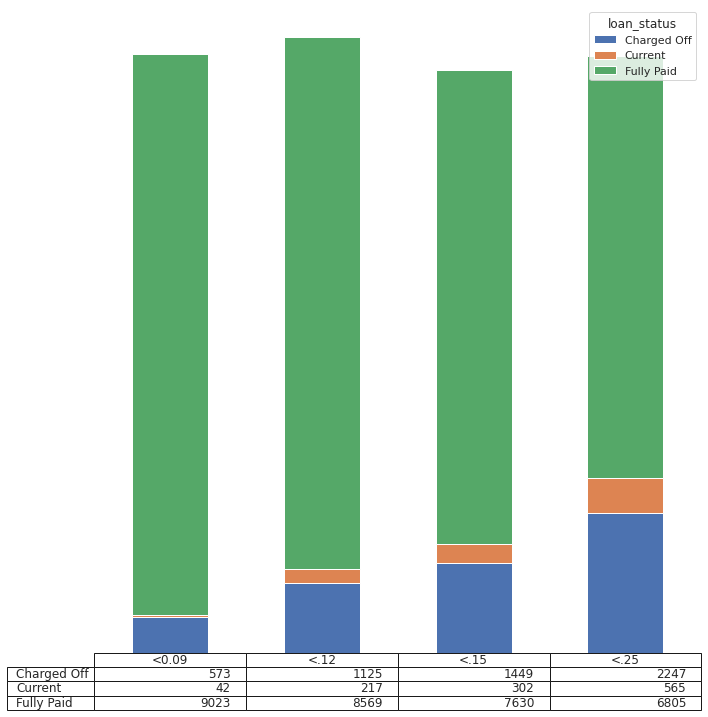

In [1454]:
bar_plot('interest_bin' ,'loan_status')

In [1455]:
pd.crosstab([df.interest_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
interest_bin,,,
<0.09,0.059452,0.004358,0.936190
<.12,0.113510,0.021895,0.864595
<.15,0.154461,0.032193,0.813346
<.25,0.233649,0.058750,0.707601


As the interest rates grow higher the chances of charging off  the loan increases.

In [1456]:
pd.crosstab([df.emp_length , df.interest_bin ],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status              Charged Off   Current  Fully Paid
emp_length interest_bin                                   
1 year     <0.09            0.064516  0.007331    0.928152
           <.12             0.134969  0.006135    0.858896
           <.15             0.128440  0.020642    0.850917
           <.25             0.219973  0.055331    0.724696
10+ years  <0.09            0.062050  0.005396    0.932554
           <.12             0.112396  0.038853    0.848751
           <.15             0.164474  0.054656    0.780870
           <.25             0.254771  0.080781    0.664447
2 years    <0.09            0.050883  0.001038    0.948079
           <.12             0.098022  0.013758    0.888220
           <.15             0.142326  0.024186    0.833488
           <.25             0.216730  0.051331    0.731939
3 years    <0.09            0.056352  0.005123    0.938525
           <.12             0.093458  0.017757    0.888785
           <.15             0.161780  0.017189    0.821031
           <.25             0.233264  0.042887    0.723849
4 years    <0.09            0.048507  0.004975    0.946517
           <.12             0.120669  0.015532    0.863799
           <.15             0.117936  0.034398    0.847666
           <.25             0.222469  0.054505    0.723026
5 years    <0.09            0.058385  0.003727    0.937888
           <.12             0.108404  0.019488    0.872107
           <.15             0.154653  0.038008    0.807339
           <.25             0.228989  0.047503    0.723508
6 years    <0.09            0.050542  0.001805    0.947653
           <.12             0.099815  0.024030    0.876155
           <.15             0.160156  0.017578    0.822266
           <.25             0.235915  0.061620    0.702465
7 years    <0.09            0.043165  0.009592    0.947242
           <.12             0.125843  0.024719    0.849438
           <.15             0.172249  0.043062    0.784689
           <.25             0.241758  0.063736    0.694505
8 years    <0.09            0.048843  0.005141    0.946015
           <.12             0.121469  0.019774    0.858757
           <.15             0.166667  0.029240    0.804094
           <.25             0.223496  0.068768    0.707736
9 years    <0.09            0.058282  0.000000    0.941718
           <.12             0.090909  0.025078    0.884013
           <.15             0.147482  0.032374    0.820144
           <.25             0.207237  0.049342    0.743421
< 1 year   <0.09            0.064663  0.000000    0.935337
           <.12             0.119674  0.009066    0.871260
           <.15             0.149445  0.017933    0.832622
           <.25             0.221450  0.042701    0.735849
Not Given  <0.09            0.115000  0.012500    0.872500
           <.12             0.192171  0.053381    0.754448
           <.15             0.339181  0.052632    0.608187
           <.25             0.297170  0.061321    0.641509

In [1457]:
pd.crosstab([df.grade , df.interest_bin ],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status         Charged Off   Current  Fully Paid
grade interest_bin                                   
A     <0.09            0.058656  0.004227    0.937117
      <.12             0.083538  0.000000    0.916462
B     <0.09            0.109091  0.000000    0.890909
      <.12             0.113153  0.023186    0.863661
      <.15             0.134986  0.058310    0.806703
C     <0.09            0.000000  0.000000    1.000000
      <.12             0.222222  0.000000    0.777778
      <.15             0.157388  0.026767    0.815846
      <.25             0.197685  0.077471    0.724844
D     <0.09            0.000000  0.000000    1.000000
      <.12             0.000000  0.000000    1.000000
      <.15             0.191131  0.000000    0.808869
      <.25             0.211081  0.048452    0.740467
E     <0.09            0.000000  0.500000    0.500000
      <.15             0.090909  0.000000    0.909091
      <.25             0.250458  0.063806    0.685735
F     <.25             0.301887  0.070506    0.627607
G     <.25             0.321192  0.056291    0.622517

In [1458]:
df.open_acc.describe()

count    38547.000000
mean         9.277739
std          4.372616
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

In [1459]:
df.open_acc.quantile([0, .25,.50,0.75 ,1])

0.00     2.0
0.25     6.0
0.50     9.0
0.75    12.0
1.00    44.0
Name: open_acc, dtype: float64

In [1460]:
df['open_acc_bin'] = pd.qcut(df.open_acc, 4, labels=['2-6','7-9','10-12','13-44'],duplicates = 'drop')

In [1461]:
df.groupby('open_acc_bin')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
open_acc_bin,,,,,,,,
2-6,11248.0,4.731063,1.200881,2.0,4.0,5.0,6.0,6.0
7-9,11372.0,7.974323,0.813682,7.0,7.0,8.0,9.0,9.0
10-12,7989.0,10.884341,0.808159,10.0,10.0,11.0,12.0,12.0
13-44,7938.0,15.970648,3.174409,13.0,14.0,15.0,17.0,44.0


In [1462]:
df.open_acc_bin.unique()

[2-6, 10-12, 13-44, 7-9]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

###Public Records/Bankrupcies/Interest/Late fee

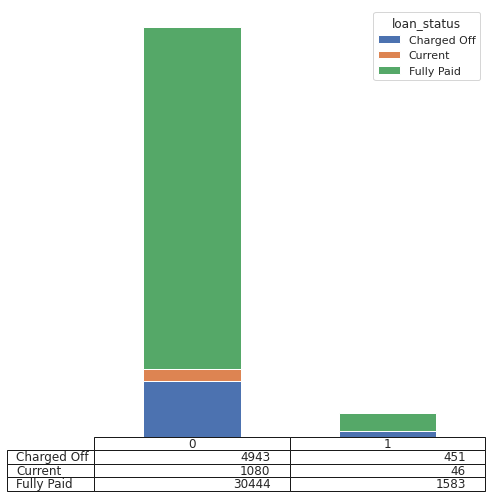

In [1463]:
df['pub_rec_exists']= df.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status',sizerow=7 , sizecolumn=7)

In [1464]:
pd.crosstab([df.pub_rec_exists],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
pub_rec_exists,,,
0,0.135547,0.029616,0.834837
1,0.216827,0.022115,0.761058


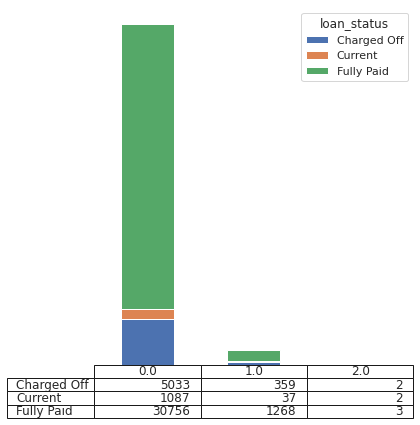

In [1465]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',sizerow=6 , sizecolumn=6)

In [1466]:
pd.crosstab([df.pub_rec_bankruptcies ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
pub_rec_bankruptcies,,,
0.0,0.136484,0.029477,0.834038
1.0,0.215745,0.022236,0.762019
2.0,0.285714,0.285714,0.428571


In [1467]:
pd.crosstab([df.pub_rec_bankruptcies ,df.pub_rec_exists ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                          Charged Off   Current  Fully Paid
pub_rec_bankruptcies pub_rec_exists                                   
0.0                  0                  0.135547  0.029616    0.834837
                     1                  0.220049  0.017115    0.762836
1.0                  1                  0.215745  0.022236    0.762019
2.0                  1                  0.285714  0.285714    0.428571

In [1468]:
pd.crosstab([df.pub_rec_bankruptcies ,df.pub_rec_exists ,df.interest_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                       Charged Off  ...  Fully Paid
pub_rec_bankruptcies pub_rec_exists interest_bin               ...            
0.0                  0              <0.09            0.059009  ...    0.936565
                                    <.12             0.112261  ...    0.864689
                                    <.15             0.150784  ...    0.815467
                                    <.25             0.227073  ...    0.713480
                     1              <0.09            0.100000  ...    0.900000
                                    <.12             0.144578  ...    0.855422
                                    <.15             0.243056  ...    0.743056
                                    <.25             0.253086  ...    0.716049
1.0                  1              <0.09            0.085938  ...    0.914062
                                    <.12             0.131579  ...    0.866228
                                    <.15             0.193939  ...    0.795960
                                    <.25             0.328205  ...    0.618803
2.0                  1              <.12             1.000000  ...    0.000000
                                    <.15             0.000000  ...    1.000000
                                    <.25             0.200000  ...    0.400000

[15 rows x 3 columns]

The chances of loan charge off is higher if banrupsies are present , even where no bankrupsy , any public record will increase chances of loan getting wrtten off

In [1469]:
df.total_rec_late_fee.describe()

count    38547.000000
mean         1.327150
std          7.134798
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64

In [1470]:
df['late_fee_status'] = df.total_rec_late_fee.apply(lambda c : 'Yes' if c>1 else 'No')

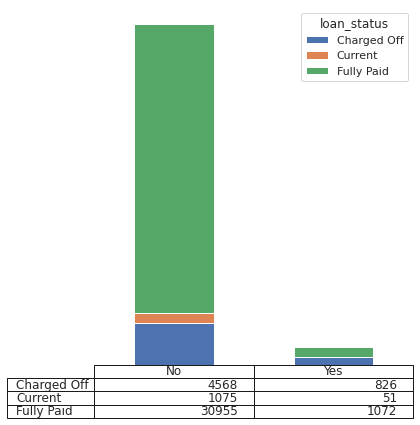

In [1471]:
bar_plot('late_fee_status' , 'loan_status',sizerow=6 , sizecolumn=6)

In [1472]:
pd.crosstab([df.late_fee_status ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
late_fee_status,,,
No,0.124816,0.029373,0.845811
Yes,0.423807,0.026167,0.550026


In [1473]:
pd.crosstab([df.late_fee_status,df.pub_rec_bankruptcies ,df.pub_rec_exists ,df.interest_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                       Charged Off  ...  Fully Paid
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin               ...            
No              0.0                  0              <0.09            0.051825  ...    0.943749
                                                    <.12             0.101980  ...    0.874444
                                                    <.15             0.133130  ...    0.831971
                                                    <.25             0.205257  ...    0.734597
                                     1              <0.09            0.100000  ...    0.900000
                                                    <.12             0.139241  ...    0.860759
                                                    <.15             0.222222  ...    0.762963
                                                    <.25             0.234899  ...    0.731544
                1.0                  1              <0.09            0.080000  ...    0.920000
                                                    <.12             0.118993  ...    0.878719
                                                    <.15             0.182979  ...    0.806383
                                                    <.25             0.315693  ...    0.631387
                2.0                  1              <.12             1.000000  ...    0.000000
                                                    <.15             0.000000  ...    1.000000
                                                    <.25             0.250000  ...    0.250000
Yes             0.0                  0              <0.09            0.350877  ...    0.644737
                                                    <.12             0.356201  ...    0.633245
                                                    <.15             0.415751  ...    0.567766
                                                    <.25             0.487591  ...    0.461314
                                     1              <.12             0.250000  ...    0.750000
                                                    <.15             0.555556  ...    0.444444
                                                    <.25             0.461538  ...    0.538462
                1.0                  1              <0.09            0.333333  ...    0.666667
                                                    <.12             0.421053  ...    0.578947
                                                    <.15             0.400000  ...    0.600000
                                                    <.25             0.513514  ...    0.432432
                2.0                  1              <.25             0.000000  ...    1.000000

[27 rows x 3 columns]

In [1474]:
dfl =df[df.late_fee_status == 'Yes']

In [1475]:
df.delinq_2yrs.describe()

count    38547.000000
mean         0.144395
std          0.488287
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64

In [1476]:
df.delinq_2yrs.value_counts()

0     34411
1      3180
2       653
3       206
4        57
5        22
6        10
7         4
8         2
11        1
9         1
Name: delinq_2yrs, dtype: int64

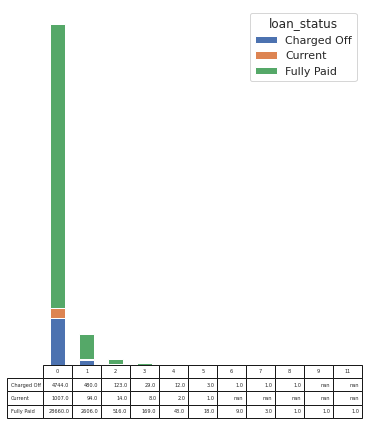

In [1477]:
bar_plot('delinq_2yrs' , 'loan_status',sizerow=6 , sizecolumn=6)

In [1478]:
df['delinq_status'] = df.delinq_2yrs.apply(lambda c : 'Yes' if c>1 else 'No')

In [1479]:
pd.crosstab([df.delinq_status, df.late_fee_status],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                    Charged Off   Current  Fully Paid
delinq_status late_fee_status                                   
No            No                  0.124206  0.029498    0.846296
              Yes                 0.422581  0.025269    0.552151
Yes           No                  0.149942  0.024221    0.825836
              Yes                 0.449438  0.044944    0.505618

In [1480]:
pd.crosstab([df.delinq_status, df.late_fee_status,df.pub_rec_bankruptcies ,df.pub_rec_exists ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                        Charged Off  ...  Fully Paid
delinq_status late_fee_status pub_rec_bankruptcies pub_rec_exists               ...            
No            No              0.0                  0                  0.119662  ...    0.850408
                                                   1                  0.201072  ...    0.780161
                              1.0                  1                  0.204545  ...    0.774026
                              2.0                  1                  0.333333  ...    0.333333
              Yes             0.0                  0                  0.421563  ...    0.552767
                                                   1                  0.461538  ...    0.538462
                              1.0                  1                  0.437500  ...    0.537500
                              2.0                  1                  0.000000  ...    1.000000
Yes           No              0.0                  0                  0.148103  ...    0.828641
                                                   1                  0.300000  ...    0.700000
                              1.0                  1                  0.150000  ...    0.800000
              Yes             0.0                  0                  0.435294  ...    0.517647
                              1.0                  1                  0.750000  ...    0.250000

[13 rows x 3 columns]

When there are 2 or more offence , its best to avoid giving loan 

###Revol Util/Income/Open acoount/Interest

In [1481]:
df.revol_util.describe()

count    38547.000000
mean         0.487672
std          0.287163
min         -1.000000
25%          0.255000
50%          0.494000
75%          0.724000
max          0.999000
Name: revol_util, dtype: float64

In [1482]:
df['Revol_util_bin'] = pd.qcut(df.revol_util, 4, labels=['Low util','Average util','High  Util' ,'Max Util'],duplicates = 'drop')

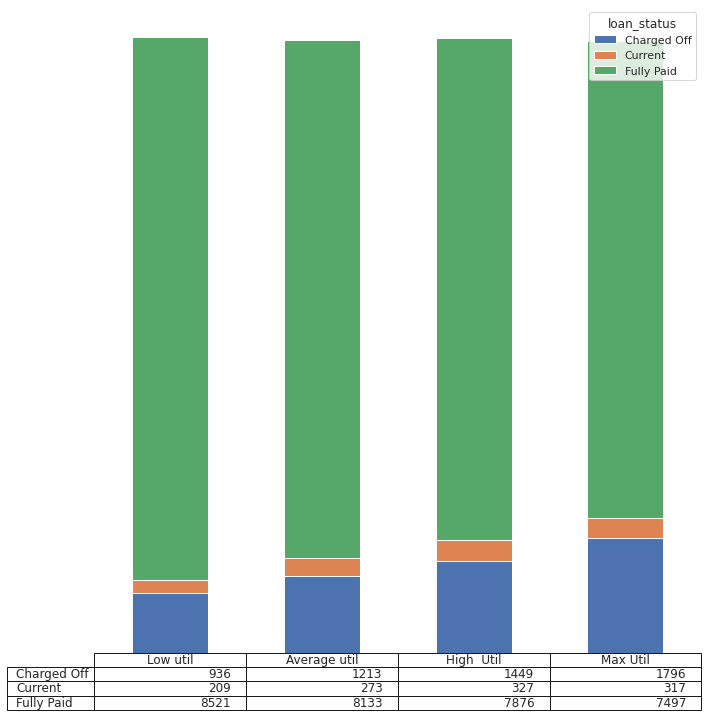

In [1483]:
bar_plot('Revol_util_bin' ,'loan_status' )

In [1484]:
 df.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'issue_year', 'annual_inc_bin', 'dti_bin',
       'Region', 'desc_len', 'desc_len_bin', 'fico', 'interest_bin',
       'open_acc_bin', 'pub_rec_exists', 'late_fee_status', 'delinq_status',
       'Revol_util_bin'],
      dtype='object')

In [1485]:
pd.crosstab([df.term,df.interest_bin , df.Revol_util_bin],df.loan_status , values= df.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                            Charged Off   Current  Fully Paid
term      interest_bin Revol_util_bin                                   
36 months <0.09        Low util           0.043152  0.000000    0.956848
                       Average util       0.060153  0.000000    0.939847
                       High  Util         0.086106  0.000000    0.913894
                       Max Util           0.091667  0.000000    0.908333
          <.12         Low util           0.088901  0.000000    0.911099
                       Average util       0.097670  0.000000    0.902330
                       High  Util         0.105357  0.000000    0.894643
                       Max Util           0.114658  0.000000    0.885342
          <.15         Low util           0.155191  0.000000    0.844809
                       Average util       0.133199  0.000000    0.866801
                       High  Util         0.124158  0.000000    0.875842
                       Max Util           0.142799  0.000000    0.857201
          <.25         Low util           0.197619  0.000000    0.802381
                       Average util       0.150943  0.000000    0.849057
                       High  Util         0.179409  0.000000    0.820591
                       Max Util           0.187950  0.000000    0.812050
60 months <0.09        Low util           0.068100  0.078853    0.853047
                       Average util       0.117647  0.095588    0.786765
                       High  Util         0.107143  0.089286    0.803571
                       Max Util           0.125000  0.250000    0.625000
          <.12         Low util           0.151589  0.108802    0.739609
                       Average util       0.152113  0.107042    0.740845
                       High  Util         0.166667  0.097778    0.735556
                       Max Util           0.193750  0.050000    0.756250
          <.15         Low util           0.176471  0.082721    0.740809
                       Average util       0.210454  0.136176    0.653370
                       High  Util         0.209859  0.142254    0.647887
                       Max Util           0.219616  0.121535    0.658849
          <.25         Low util           0.239923  0.101727    0.658349
                       Average util       0.267606  0.085513    0.646881
                       High  Util         0.259975  0.110349    0.629676
                       Max Util           0.294323  0.109170    0.596507

In [1486]:
df60 = df[(df.term == '60 months') & (df.interest_bin.isin(['<.15','<.25']))]
pd.crosstab([df60.interest_bin , df60.Revol_util_bin],df60.loan_status , values= df60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                  Charged Off   Current  Fully Paid
interest_bin Revol_util_bin                                   
<.15         Low util           0.176471  0.082721    0.740809
             Average util       0.210454  0.136176    0.653370
             High  Util         0.209859  0.142254    0.647887
             Max Util           0.219616  0.121535    0.658849
<.25         Low util           0.239923  0.101727    0.658349
             Average util       0.267606  0.085513    0.646881
             High  Util         0.259975  0.110349    0.629676
             Max Util           0.294323  0.109170    0.596507

In [1487]:
df.emp_length.value_counts()

10+ years    8615
< 1 year     4379
2 years      4253
3 years      3991
4 years      3354
5 years      3210
1 year       3110
6 years      2175
7 years      1735
8 years      1434
9 years      1227
Not Given    1064
Name: emp_length, dtype: int64

In [1488]:
pd.crosstab([df60.interest_bin , df60.Revol_util_bin,df60.annual_inc_bin],df60.loan_status , values= df60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off   Current  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                                   
<.15         Low util       Low Income         0.305556  0.046296    0.648148
                            Average Income     0.196970  0.113636    0.689394
                            High  Income       0.130137  0.047945    0.821918
                            Business class     0.113924  0.113924    0.772152
             Average util   Low Income         0.304965  0.070922    0.624113
                            Average Income     0.213115  0.180328    0.606557
                            High  Income       0.219388  0.153061    0.627551
                            Business class     0.135266  0.125604    0.739130
             High  Util     Low Income         0.354167  0.111111    0.534722
                            Average Income     0.181287  0.146199    0.672515
                            High  Income       0.211640  0.126984    0.661376
                            Business class     0.131068  0.174757    0.694175
             Max Util       Low Income         0.287500  0.150000    0.562500
                            Average Income     0.296610  0.118644    0.584746
                            High  Income       0.141791  0.089552    0.768657
                            Business class     0.189781  0.138686    0.671533
<.25         Low util       Low Income         0.319328  0.067227    0.613445
                            Average Income     0.188034  0.153846    0.658120
                            High  Income       0.285714  0.100000    0.614286
                            Business class     0.172414  0.089655    0.737931
             Average util   Low Income         0.288557  0.084577    0.626866
                            Average Income     0.262500  0.095833    0.641667
                            High  Income       0.359504  0.041322    0.599174
                            Business class     0.186495  0.112540    0.700965
             High  Util     Low Income         0.285714  0.084942    0.629344
                            Average Income     0.281928  0.122892    0.595181
                            High  Income       0.266968  0.113122    0.619910
                            Business class     0.221311  0.110656    0.668033
             Max Util       Low Income         0.382514  0.092896    0.524590
                            Average Income     0.307554  0.106115    0.586331
                            High  Income       0.312903  0.104839    0.582258
                            Business class     0.225936  0.122995    0.651070

In [1489]:
df60 = df60[df60.Revol_util_bin >'Average util']
df60.shape

(5073, 57)

In [1490]:
pd.crosstab([df60.interest_bin , df60.Revol_util_bin,df60.annual_inc_bin],df60.loan_status , values= df60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off   Current  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                                   
<.15         High  Util     Low Income         0.354167  0.111111    0.534722
                            Average Income     0.181287  0.146199    0.672515
                            High  Income       0.211640  0.126984    0.661376
                            Business class     0.131068  0.174757    0.694175
             Max Util       Low Income         0.287500  0.150000    0.562500
                            Average Income     0.296610  0.118644    0.584746
                            High  Income       0.141791  0.089552    0.768657
                            Business class     0.189781  0.138686    0.671533
<.25         High  Util     Low Income         0.285714  0.084942    0.629344
                            Average Income     0.281928  0.122892    0.595181
                            High  Income       0.266968  0.113122    0.619910
                            Business class     0.221311  0.110656    0.668033
             Max Util       Low Income         0.382514  0.092896    0.524590
                            Average Income     0.307554  0.106115    0.586331
                            High  Income       0.312903  0.104839    0.582258
                            Business class     0.225936  0.122995    0.651070

In [1491]:
df60 = df60[df60.annual_inc_bin < 'High  Income']

In [1492]:
pd.crosstab([df60.interest_bin , df60.Revol_util_bin,df60.annual_inc_bin],df60.loan_status , values= df60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off   Current  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                                   
<.15         High  Util     Low Income         0.354167  0.111111    0.534722
                            Average Income     0.181287  0.146199    0.672515
             Max Util       Low Income         0.287500  0.150000    0.562500
                            Average Income     0.296610  0.118644    0.584746
<.25         High  Util     Low Income         0.285714  0.084942    0.629344
                            Average Income     0.281928  0.122892    0.595181
             Max Util       Low Income         0.382514  0.092896    0.524590
                            Average Income     0.307554  0.106115    0.586331

In [1493]:
df60.open_acc_bin.unique()

[7-9, 13-44, 10-12, 2-6]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

In [1494]:
df60 = df60[df60.annual_inc_bin == 'Low Income']
pd.crosstab([df60.interest_bin , df60.Revol_util_bin,df60.annual_inc_bin,df60.open_acc_bin],df60.loan_status , values= df60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                              Charged Off  ...  Fully Paid
interest_bin Revol_util_bin annual_inc_bin open_acc_bin               ...            
<.15         High  Util     Low Income     2-6              0.303571  ...    0.589286
                                           7-9              0.396226  ...    0.471698
                                           10-12            0.454545  ...    0.454545
                                           13-44            0.230769  ...    0.692308
             Max Util       Low Income     2-6              0.276596  ...    0.574468
                                           7-9              0.400000  ...    0.500000
                                           10-12            0.111111  ...    0.777778
                                           13-44            0.250000  ...    0.250000
<.25         High  Util     Low Income     2-6              0.284314  ...    0.666667
                                           7-9              0.246914  ...    0.654321
                                           10-12            0.285714  ...    0.571429
                                           13-44            0.450000  ...    0.500000
             Max Util       Low Income     2-6              0.349057  ...    0.570755
                                           7-9              0.382979  ...    0.521277
                                           10-12            0.500000  ...    0.394737
                                           13-44            0.500000  ...    0.318182

[16 rows x 3 columns]

#Decision Tree

In [1495]:
df_decision = df.drop(['annual_inc', 'total_rec_late_fee','delinq_2yrs','desc_len', 'pub_rec','total_rec_late_fee','revol_util','desc'],axis = 1)
df_decision = df_decision[~(df_decision.loan_status=='Current') ]

In [1496]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [1497]:
feature_col = [ 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
        'installment', 'grade', 'sub_grade', 
       'emp_length', 'home_ownership', 'verification_status', 
        'purpose',  
        'inq_last_6mths', 'mths_since_last_delinq',
         'revol_bal',  
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'recoveries', 'collection_recovery_fee', 
       'last_pymnt_amnt',  'pub_rec_bankruptcies',
        'annual_inc_bin', 'dti_bin', 'Region', 'desc_len_bin',
       'fico', 'interest_bin', 'open_acc_bin', 'pub_rec_exists',
       'late_fee_status', 'delinq_status', 'Revol_util_bin']


feature_cols = [ 'loan_amnt', 'funded_amnt',  'term',
         'grade', 'sub_grade', 
       'emp_length', 'home_ownership', 'verification_status', 
        'purpose',  
        'inq_last_6mths', 'mths_since_last_delinq'
        
       ,  'pub_rec_bankruptcies',
        'annual_inc_bin', 'dti_bin', 'Region', 'interest_bin', 
        'open_acc_bin', 'pub_rec_exists',
       'late_fee_status', 'delinq_status', 'Revol_util_bin']



X = df_decision[feature_cols] # Features
y = df_decision.loan_status

In [1498]:
X.shape

(37421, 21)

In [1499]:
X = pd.get_dummies(X[feature_cols])
cols =X.columns
target =  y.unique()

In [1500]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [1501]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [1503]:
from graphviz import Source
from sklearn.tree import export_graphviz
from subprocess import check_call

export_graphviz(
        clf,
        out_file="tree.dot",
        feature_names=cols,
        class_names=target,
        rounded=True,
        filled=True
    )
check_call(['dot','-Tpng','tree.dot','-o','OutputFile.png'])